# Child Tax Credit returns in 2015

Count tax returns and total amount for Child Tax Credit. Compare to [IRS SOI](https://www.irs.gov/statistics/soi-tax-stats-individual-statistical-tables-by-size-of-adjusted-gross-income) "All Returns: Tax Liability, Tax Credits, and Tax Payments" table ([spreadsheet](https://docs.google.com/spreadsheets/d/1s8Z9E-n_eojbeXvEmCPCaSH7zZ4Nnsk-7VZeAGJjvFs/edit#gid=1511153420)). This is to compare CPS and PUF accuracy for measuring CTC in [Tax-Calculator #1929](https://github.com/open-source-economics/Tax-Calculator/issues/1929#issuecomment-374318724).

*Data: CPS  |  Tax year: 2018  |  Type: Static  |  Author: Max Ghenis  |  Date run: 2018-03-24*

## Setup

### Imports

In [1]:
import taxcalc as tc
import pandas as pd
import numpy as np
import copy
from bokeh.io import show, output_notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# On Python 3.6 use "import urllib.request as url_lib".
import urllib as url_lib

In [2]:
tc.__version__

'0.17.0'

### Settings

In [3]:
sns.set_style('white')
DPI = 300
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

In [6]:
def weighted_sum(df, col):
    return (df[col] * df.s006).sum()

## Data

### Tax-Calculator

In [7]:
recs = tc.Records.cps_constructor()
LABEL = 'CPS'

In [8]:
calc = tc.Calculator(records=recs, policy=tc.Policy(), verbose=False)
calc.advance_to_year(2015)
calc.calc_all()
tcdf = calc.dataframe(['s006',  # Weight.
                       'c07220',  # Child Tax Credit.
                       'c11070',  # Additional Child Tax Credit.
                       'c00100'  # Adjusted Gross Income.
                      ])

### SOI

Ideally load using a Google Sheets or CSV reader, or `read_table`.

In [9]:
soi = pd.DataFrame({
    'agi_min': [-1e9, 0, 5000, 10000, 15000, 20000, 25000, 30000, 40000,
                50000, 75000, 100000, 200000],
    'agi_max': [0, 5000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 
                75000, 100000, 200000, 1e9],
    'soi_ctc_returns': [6316, 3994, 11181, 57064, 555455, 1144357, 1656830,
                        3348790, 2791873, 5314652, 3694847, 3789389, 2143],
    'soi_ctc_amount': [4319, 1809, 3662, 8399, 99901, 439625, 950879, 2824166, 
                       3260947, 8148380, 6198633, 5157458, 1797],
    # ACTC returns equal refundable plus offset, so are overestimated.
    'soi_actc_returns': [86995, 356956, 1942346, 3531918, 3495576, 2911368, 
                         2322219, 2961150, 1473946, 1047139, 152281, 42775, 
                         29],
    'soi_actc_amount': [125806, 77452, 1470338, 4249612, 5110491, 4218529, 
                        3365761, 4407862, 2023871, 1266751, 208865, 64724, 
                        48]})

SOI reports in thousands.

In [10]:
soi['soi_ctc_amount'] = soi.soi_ctc_amount * 1000
soi['soi_actc_amount'] = soi.soi_actc_amount * 1000

## Preprocess

Add AGI buckets to `tcdf`, sum totals, and join the tables.

In [11]:
cut_points = pd.concat([pd.Series(soi.iloc[0].agi_min), soi.agi_max])
# TODO: Use include_lowest, doesn't seem to be working now. Should be tiny.
tcdf['agi_bucket'] = pd.cut(tcdf.c00100, cut_points)

In [12]:
tcdf['tc_ctc_amount'] = tcdf.s006 * tcdf.c07220
tcdf['tc_actc_amount'] = tcdf.s006 * tcdf.c11070
tcdf['tc_ctc_returns'] = np.where(tcdf.c07220 > 0, tcdf.s006, 0)
tcdf['tc_actc_returns'] = np.where(tcdf.c11070 > 0, tcdf.s006, 0)

In [13]:
TC_COLS = ['tc_ctc_amount', 'tc_actc_amount', 
           'tc_ctc_returns', 'tc_actc_returns']
tc_summary = tcdf.groupby('agi_bucket')[TC_COLS].sum()

In [14]:
comp = pd.concat([tc_summary.reset_index(drop=True), soi], axis=1)
comp.index = ['Nonpositive',
              '(\$0, \$5k)',
              '[\$5k, \$10k)',
              '[\$10k, \$15k)',
              '[\$15k, \$20k)',
              '[\$20k, \$25k)',
              '[\$25k, \$30k)',
              '[\$30k, \$40k)',
              '[\$40k, \$50k)',
              '[\$50k, \$75k)',
              '[\$75k, \$100k)',
              '[\$100k, \$200k)',
              '>$200k']

In [15]:
comp['soi_ctc_amount_b'] = comp.soi_ctc_amount / 1e9
comp['tc_ctc_amount_b'] = comp.tc_ctc_amount / 1e9
comp['soi_ctc_returns_m'] = comp.soi_ctc_returns / 1e6
comp['tc_ctc_returns_m'] = comp.tc_ctc_returns / 1e6
comp['soi_actc_amount_b'] = comp.soi_actc_amount / 1e9
comp['tc_actc_amount_b'] = comp.tc_actc_amount / 1e9
comp['soi_actc_returns_m'] = comp.soi_actc_returns / 1e6
comp['tc_actc_returns_m'] = comp.tc_actc_returns / 1e6
# Add CTC and ACTC.
comp['tc_tctc_amount_b'] = comp.tc_ctc_amount_b + comp.tc_actc_amount_b
comp['soi_tctc_amount_b'] = comp.soi_ctc_amount_b + comp.soi_actc_amount_b

In [16]:
total_comp = comp[['soi_ctc_returns_m', 'tc_ctc_returns_m', 
                   'soi_ctc_amount_b', 'tc_ctc_amount_b',
                   'soi_actc_returns_m', 'tc_actc_returns_m', 
                   'soi_actc_amount_b', 'tc_actc_amount_b',
                   'soi_tctc_amount_b', 'tc_tctc_amount_b']].sum()

In [17]:
total_amount = pd.DataFrame({
    'soi': [total_comp.soi_ctc_amount_b, total_comp.soi_actc_amount_b, 
            total_comp.soi_tctc_amount_b],
    'tc': [total_comp.tc_ctc_amount_b, total_comp.tc_actc_amount_b, 
          total_comp.tc_tctc_amount_b]
    },
    index=['CTC', 'ACTC', 'CTC+ACTC']
)
total_amount['diff'] = total_amount.tc / total_amount.soi - 1

In [18]:
total_amount

,soi,tc,diff
CTC,27.10,32.34,0.19
ACTC,26.59,20.68,-0.22
CTC+ACTC,53.69,53.02,-0.01


## Plot

In [19]:
tc_label = 'Tax-Calculator (' + LABEL + ')'
legend_text = ['SOI', tc_label]

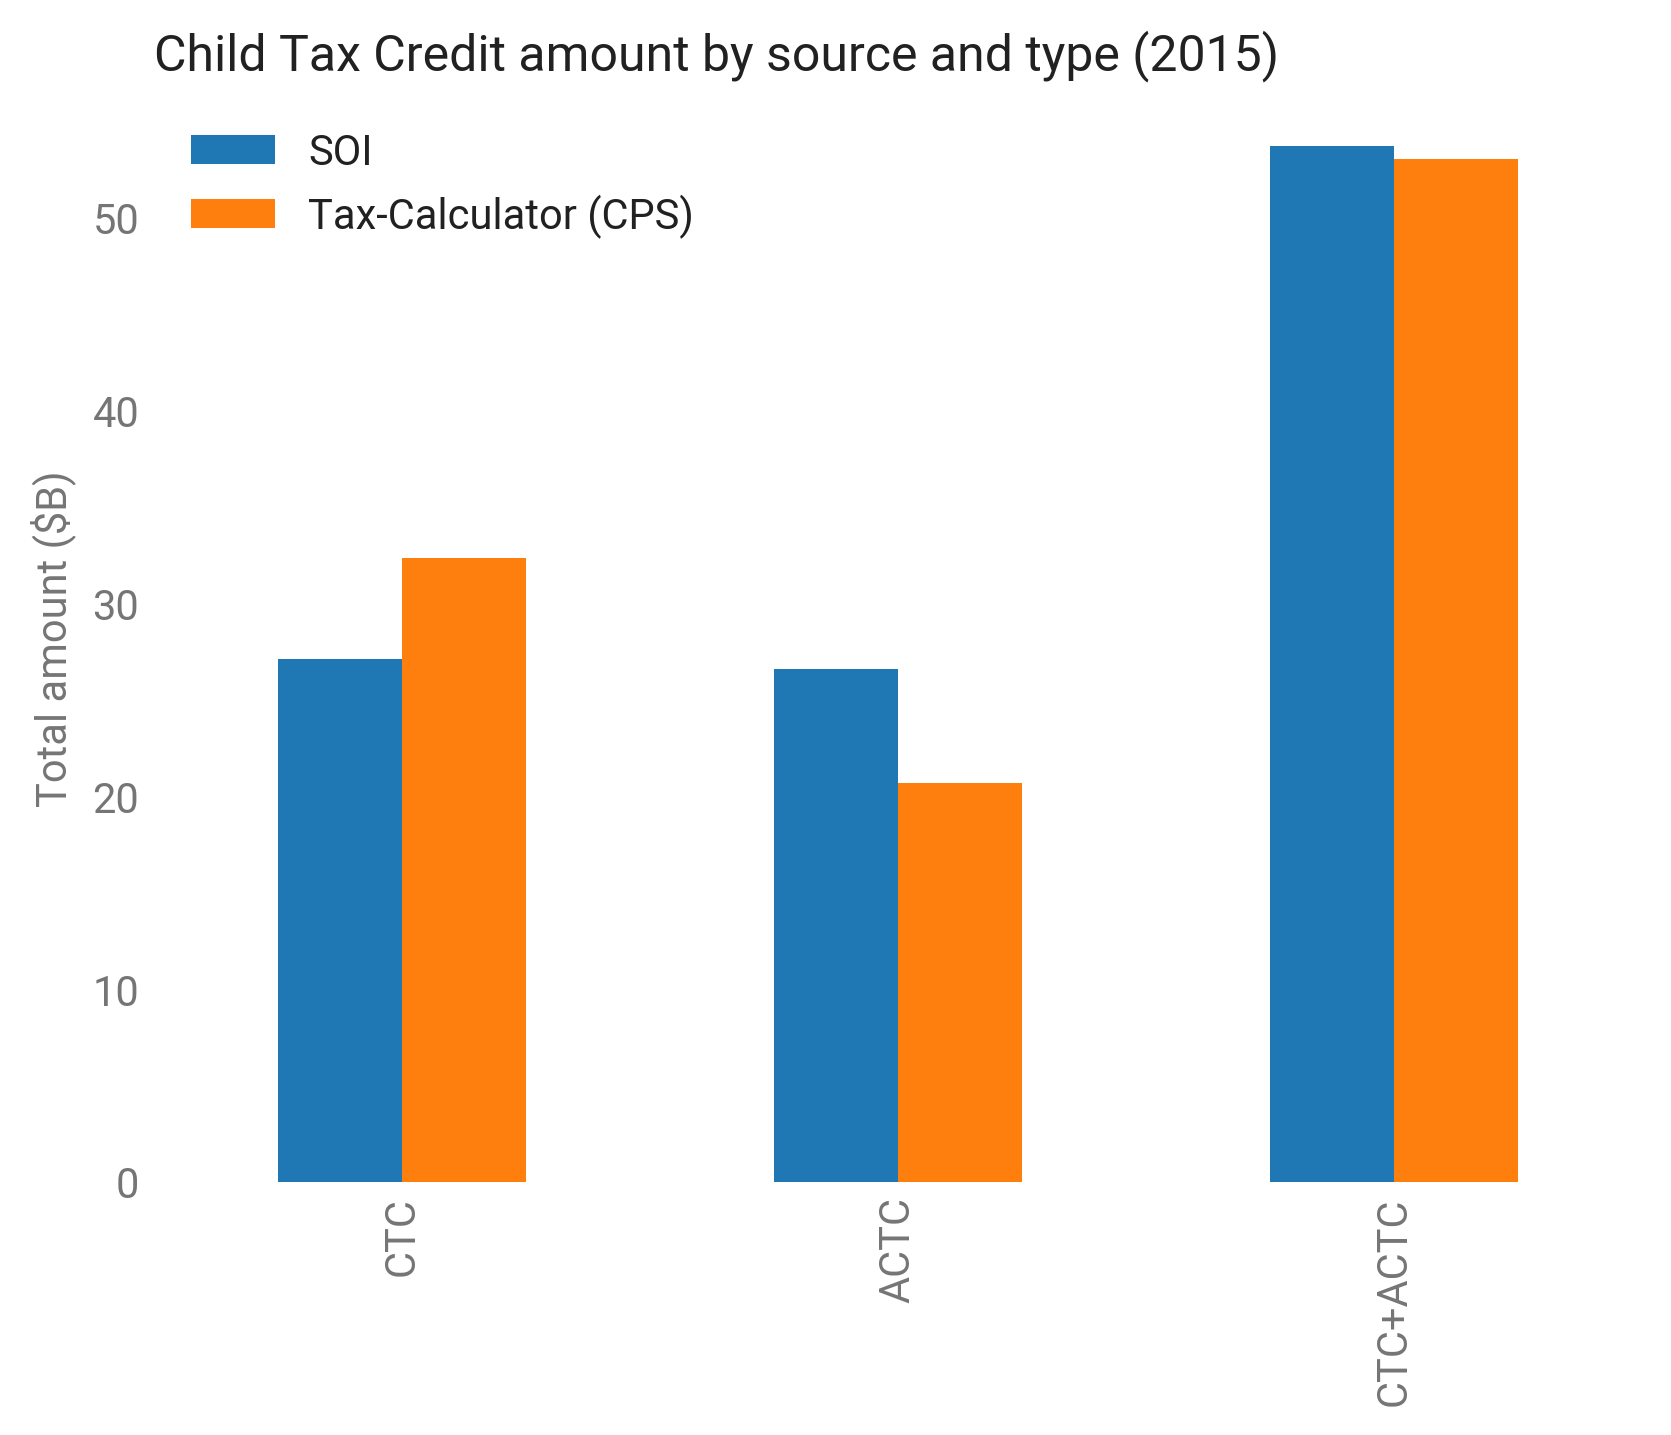

In [20]:
ax = total_amount[['soi', 'tc']].plot.bar()
plt.legend(legend_text)
sns.despine(left=True, bottom=True)
ax.set(ylabel='Total amount ($B)')
plt.title('Child Tax Credit amount by source and type (2015)', loc='left')
plt.show()

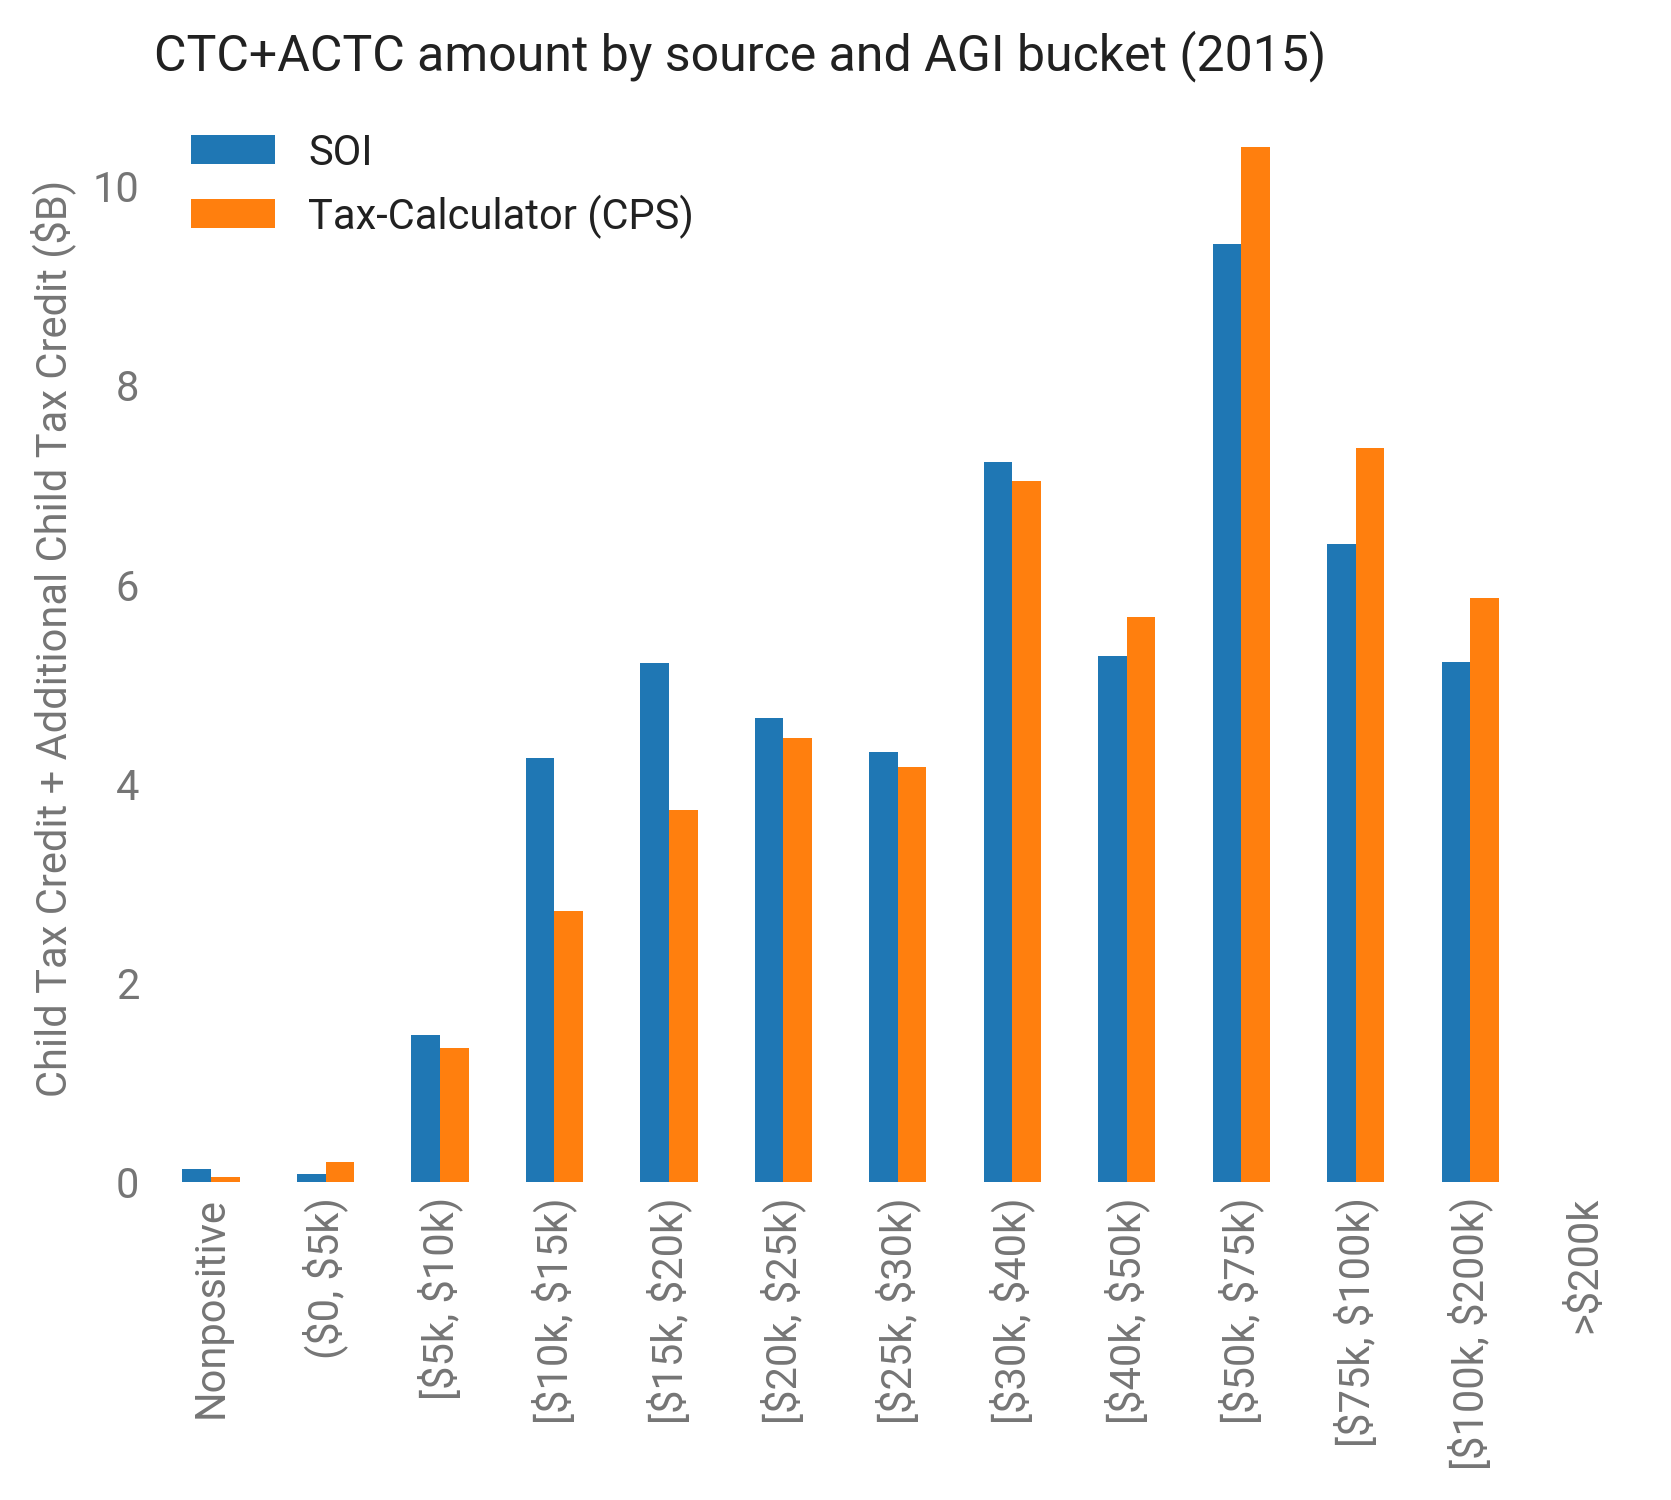

In [21]:
ax = comp[['soi_tctc_amount_b', 'tc_tctc_amount_b']].plot.bar()
plt.legend(legend_text)
sns.despine(left=True, bottom=True)
ax.set(ylabel='Child Tax Credit + Additional Child Tax Credit ($B)')
plt.title('CTC+ACTC amount by source and AGI bucket (2015)', loc='left')
plt.show()

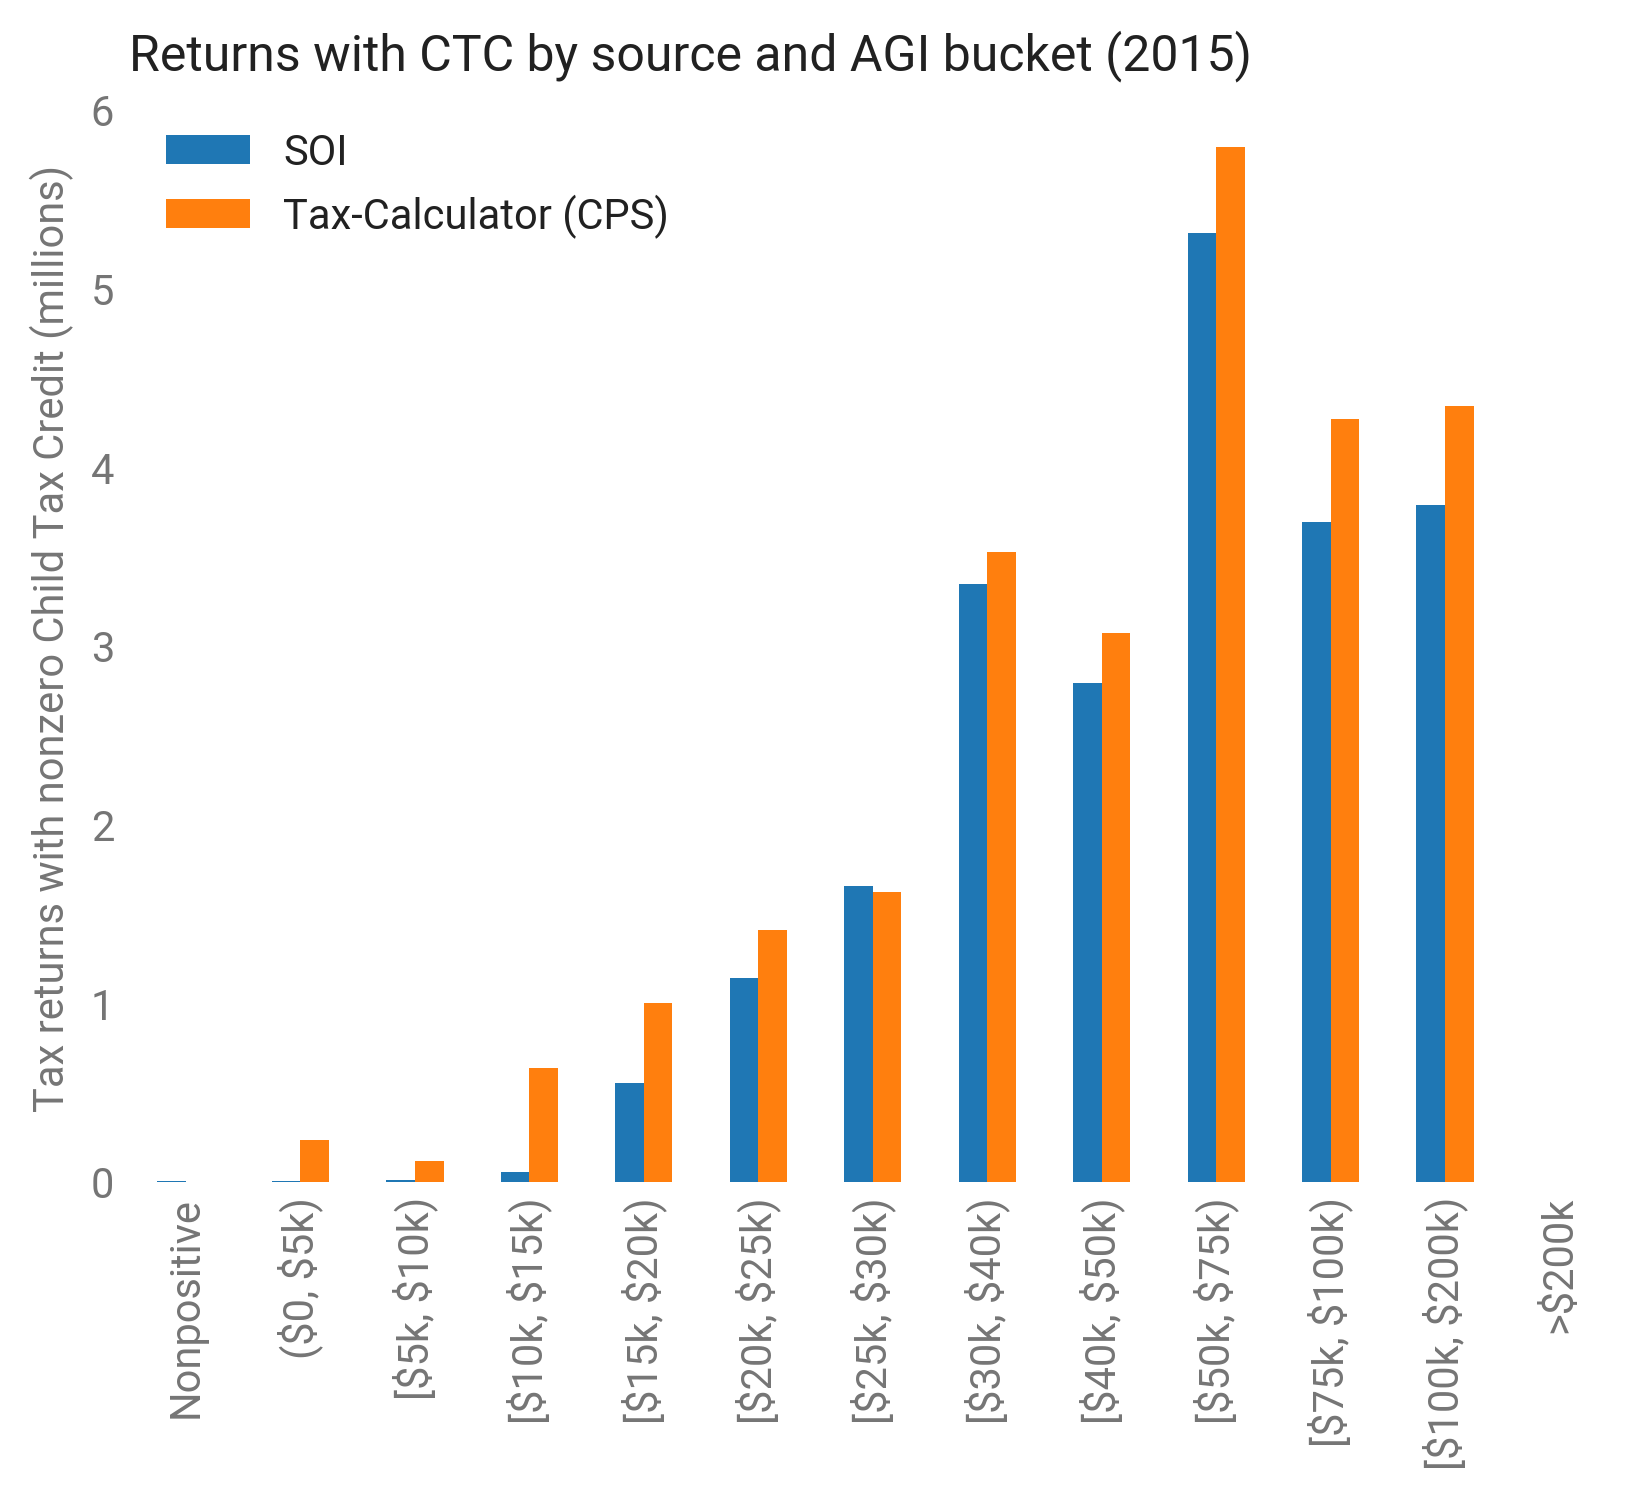

In [22]:
ax = comp[['soi_ctc_returns_m', 'tc_ctc_returns_m']].plot.bar()
plt.legend(legend_text)
sns.despine(left=True, bottom=True)
ax.set(ylabel='Tax returns with nonzero Child Tax Credit (millions)')
plt.title('Returns with CTC by source and AGI bucket (2015)', loc='left')
plt.show()

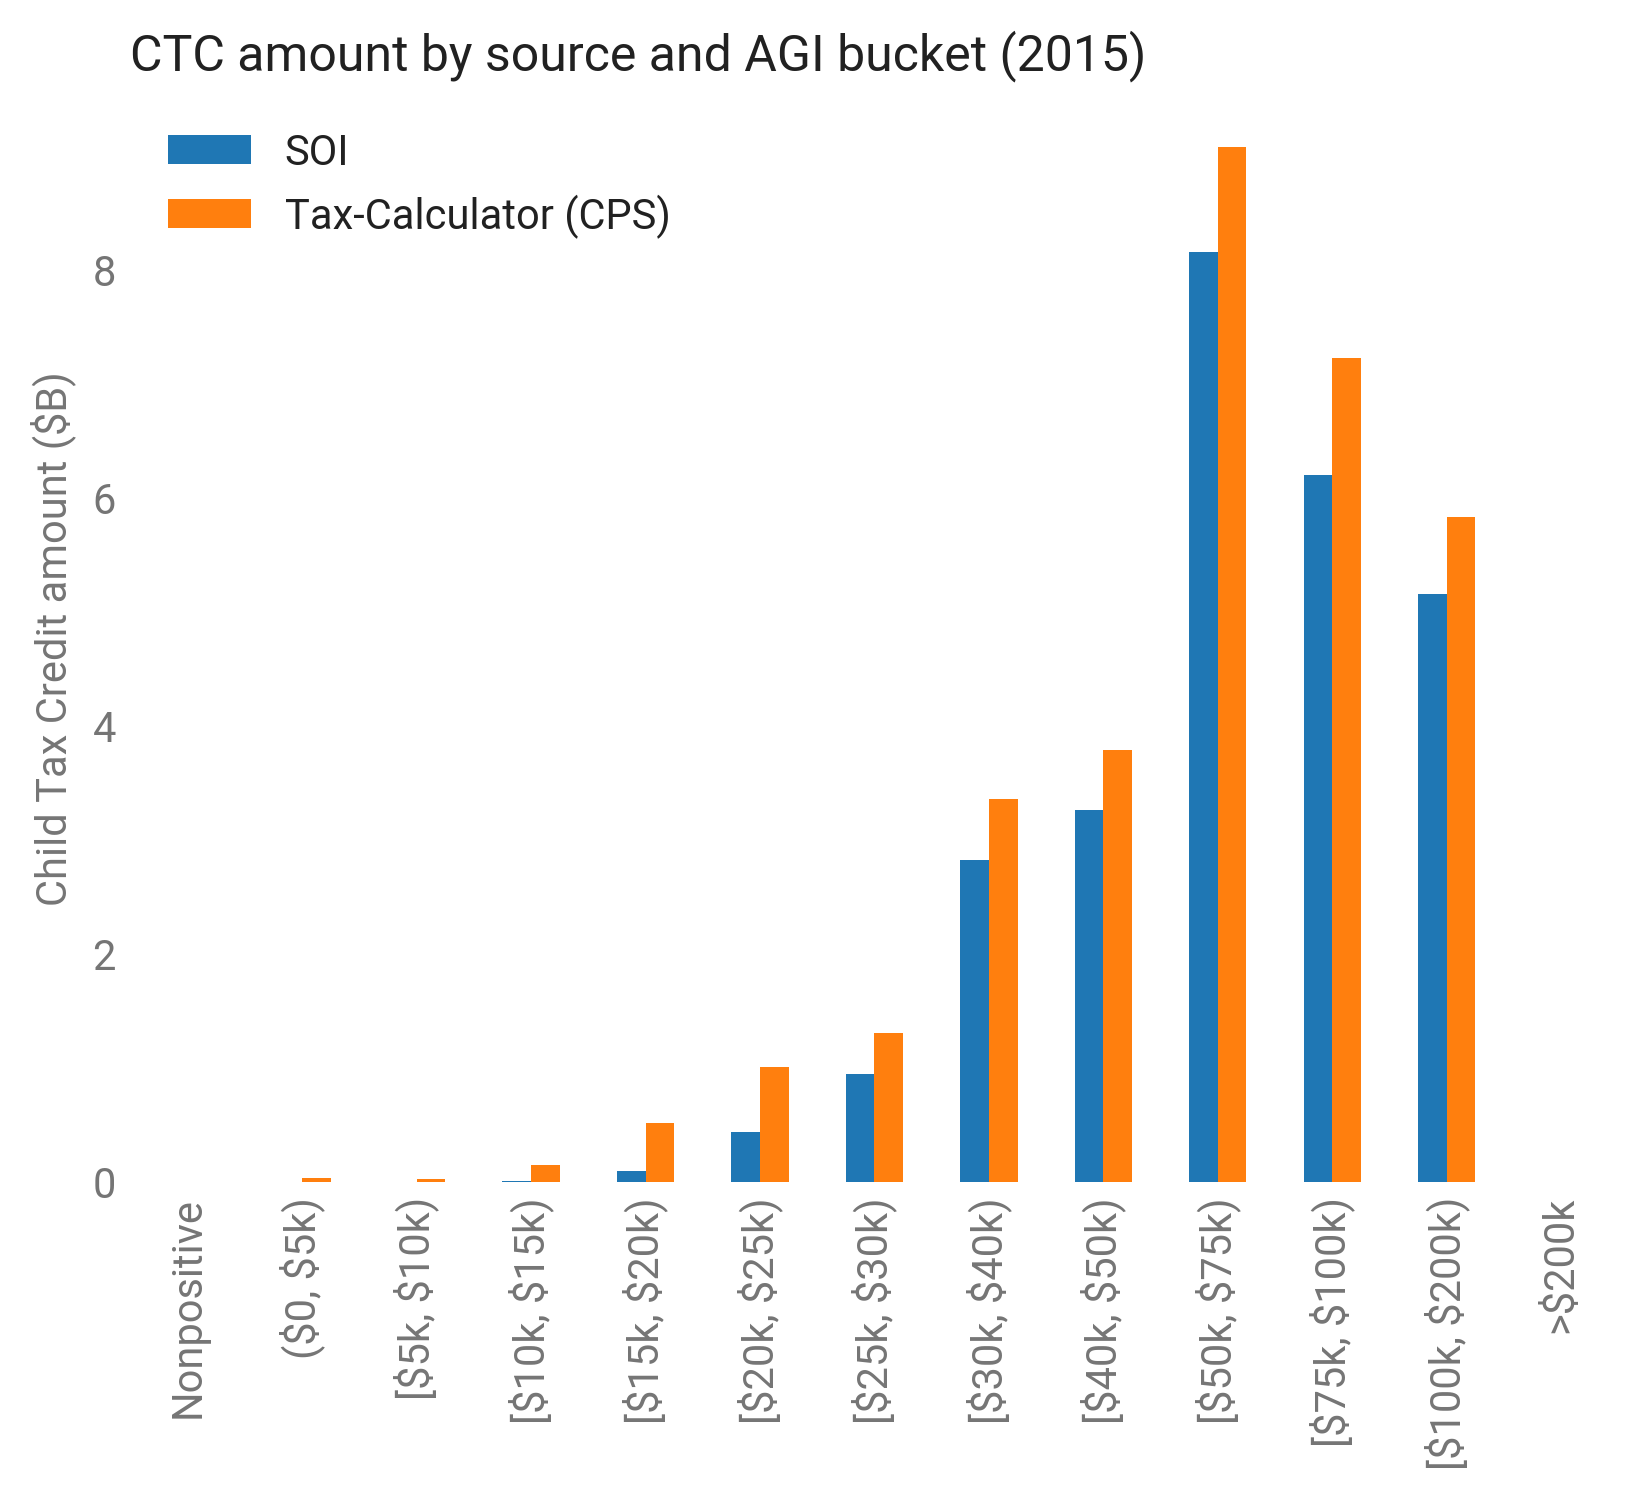

In [23]:
ax = comp[['soi_ctc_amount_b', 'tc_ctc_amount_b']].plot.bar()
plt.legend(legend_text)
sns.despine(left=True, bottom=True)
ax.set(ylabel='Child Tax Credit amount ($B)')
plt.title('CTC amount by source and AGI bucket (2015)', loc='left')
plt.show()

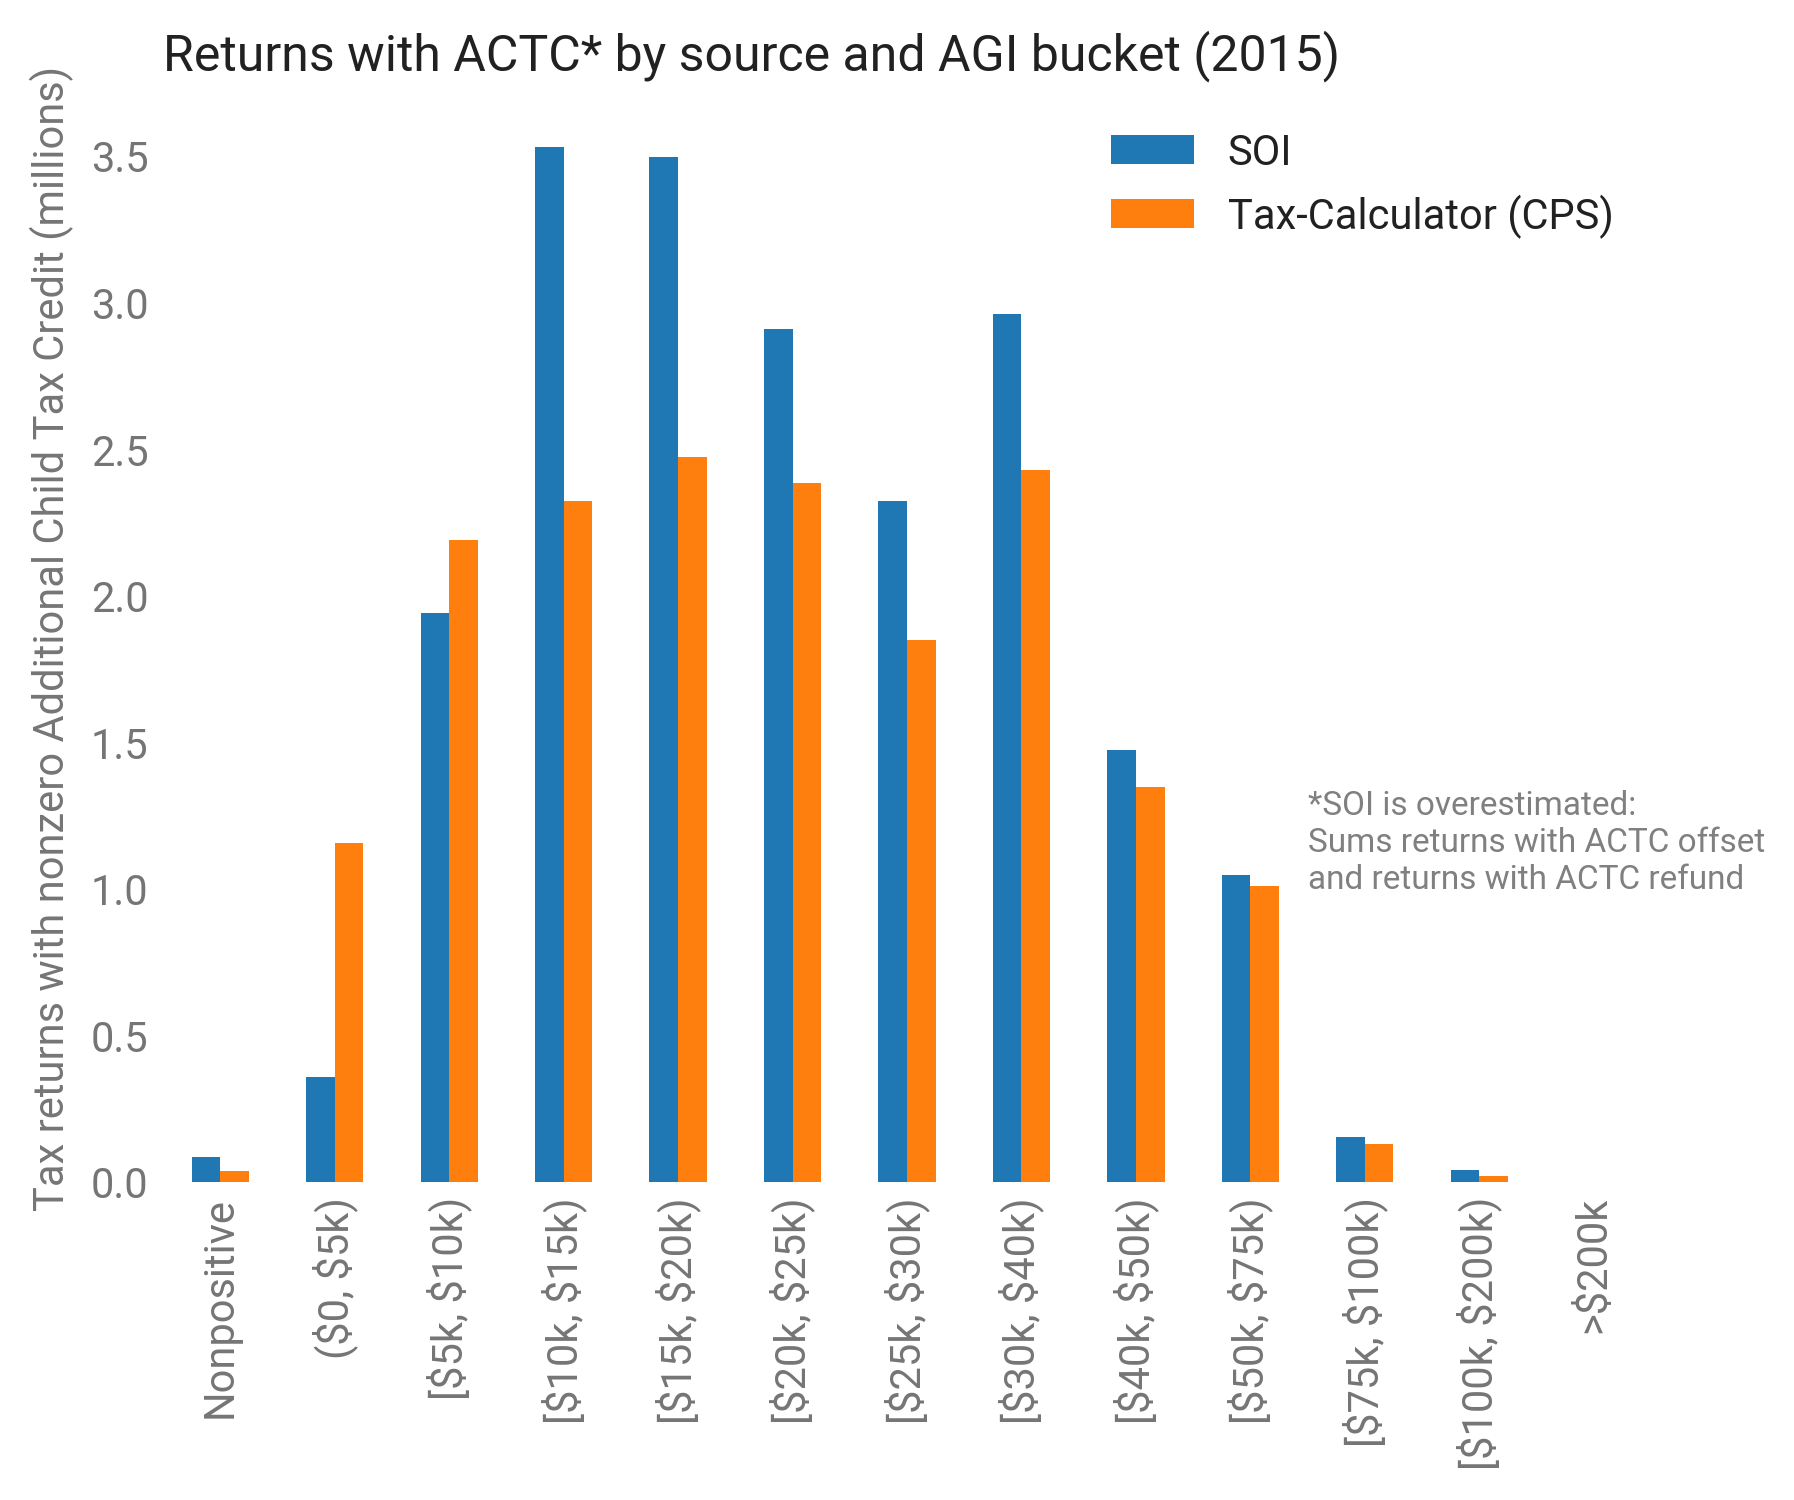

In [24]:
ax = comp[['soi_actc_returns_m', 'tc_actc_returns_m']].plot.bar()
plt.legend(legend_text)
sns.despine(left=True, bottom=True)
ax.set(ylabel='Tax returns with nonzero Additional Child Tax Credit ' +
       '(millions)')
plt.title('Returns with ACTC* by source and AGI bucket (2015)', loc='left')
ax.text(9.5, 1, 
        '*SOI is overestimated:\n' +
        'Sums returns with ACTC offset\n' +
        'and returns with ACTC refund',
        horizontalalignment='left', color='gray', size=8)
plt.show()

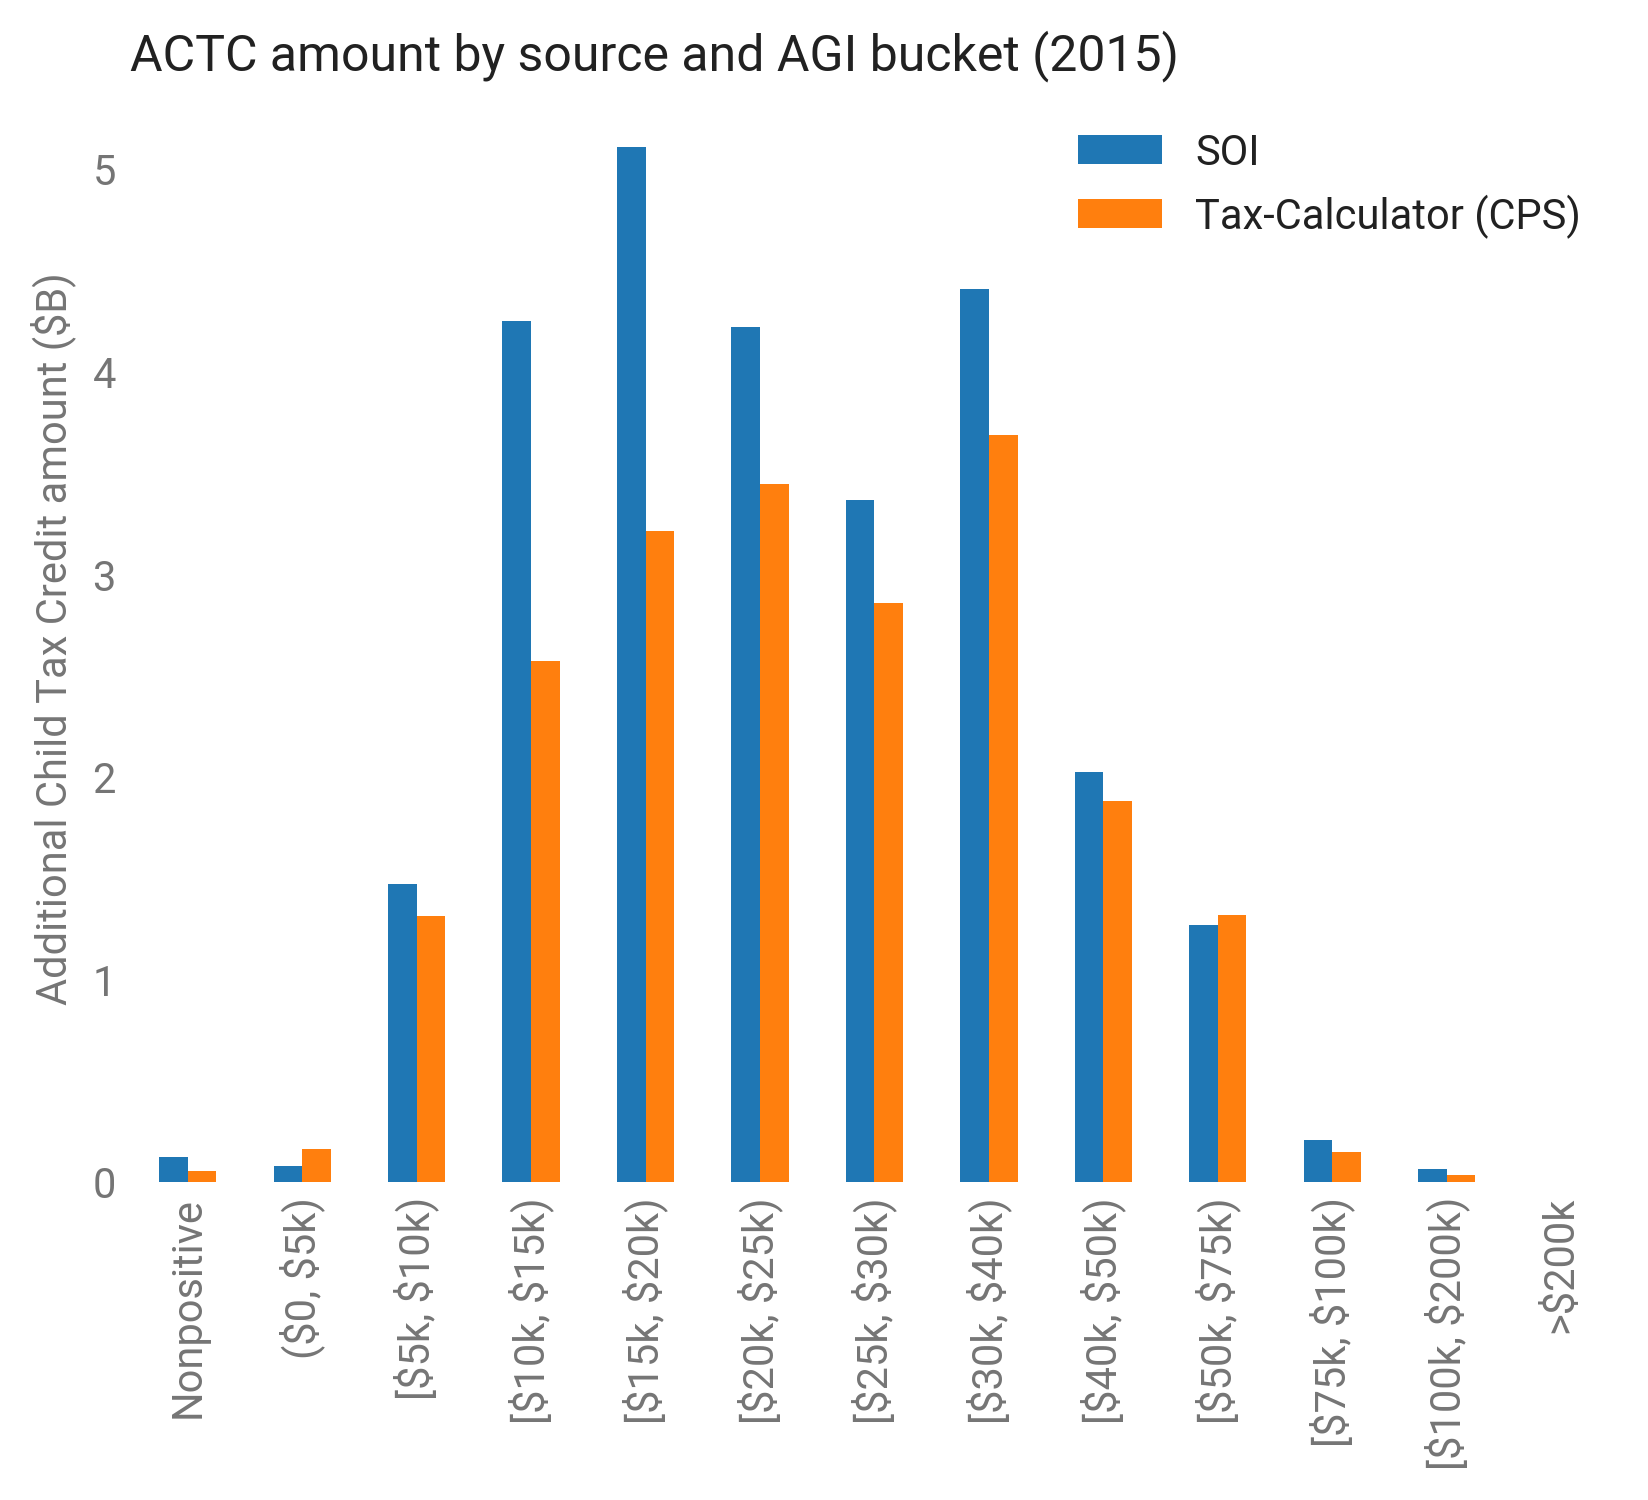

In [25]:
ax = comp[['soi_actc_amount_b', 'tc_actc_amount_b']].plot.bar()
plt.legend(legend_text)
sns.despine(left=True, bottom=True)
ax.set(ylabel='Additional Child Tax Credit amount ($B)')
plt.title('ACTC amount by source and AGI bucket (2015)', loc='left')
plt.show()